In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import numpy as np
import os 
from torch_geometric.loader import DataLoader

from ChromFormer.Data_Tools.Data_Access import get_data_from_path, VanillaDataset, set_logits_data
from ChromFormer.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances, plot_grad_flow, plot_pred_conf
from ChromFormer.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear, ConfLinear, train_conf_linear, evaluate_conf_linear, TransConf, train_trans_conf, evaluate_trans_conf
from ChromFormer.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from ChromFormer.Data_Tools.Data_Calculation import save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif, scale_logits, mse_unscaled_scaled
from ChromFormer.Model.lddt_tools import lddt, get_confidence_metrics
from ChromFormer.Model.calibration_nn import ModelWithTemperature, isotonic_calibration, beta_calibration
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

NB_HEAD = 2
NB_HIDDEN = 100
#100
NB_LAYERS = 1
DROPOUT = 0.1
SECD_HID = 48
#48
ZERO_INIT = False
EXPONENT = 1
NUM_BINS_LOGITS = 100
NB_EPOCHS = 96
##91
##47
SEED = 2
BATCH_SIZE = 10
NB_BINS = 202
EMBEDDING_SIZE = 3
ANGLE_PRED = 3
LAMBDA_BIO = 0.1
LAMBDA_KABSCH = 0.1
#0.1
LAMBDA_LDDT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
DATA_DIR = os.environ.get('DATA_TECH')
DATA_PATH=f'{DATA_DIR}/synthetic_random'
TRAIN_DATASET_SIZE = 800
TEST_DATASET_SIZE = 200



In [3]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


In [4]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

100%|██████████| 800/800 [00:00<00:00, 37571.17it/s]

Processing...


Done!
800


In [5]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()

test_train_idx, test_test_idx = train_test_split(list(range(len(test_dataset))), test_size=0.1)
test_train_calib = test_dataset.index_select(test_train_idx)
test_test_calib= test_dataset.index_select(test_test_idx)

test_size = len(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
test_train_calib_loader = DataLoader(test_train_calib, batch_size=BATCH_SIZE)
test_test_calib_loader = DataLoader(test_test_calib, batch_size=BATCH_SIZE)

100%|██████████| 200/200 [00:00<00:00, 43140.18it/s]

Processing...
Done!


In [6]:
trussart_hic, trussart_structures = import_trussart_data(DATA_DIR)

In [7]:
distance_loss_fct = torch.nn.MSELoss()

In [8]:
device = torch.device('cpu')
model = TransConf(NB_BINS, ANGLE_PRED, BATCH_SIZE, NUM_BINS_LOGITS, ZERO_INIT, NB_HEAD, NB_HIDDEN, NB_LAYERS, DROPOUT, SECD_HID).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

In [9]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []
train_lddt_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []
test_lddt_losses_all_epochs = []

losses = []

trussart_test_kabsch_losses_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train_trans_conf(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct, LAMBDA_LDDT, NUM_BINS_LOGITS)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances, train_mean_lddt_loss = evaluate_trans_conf(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    train_lddt_losses_all_epochs.append(train_mean_lddt_loss)

    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances, test_mean_lddt_loss = evaluate_trans_conf(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    ### Trussart test
    trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss(trussart_hic, trussart_structures, model, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    save_structure(model, epoch, trussart_structures, trussart_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    test_lddt_losses_all_epochs.append(test_mean_lddt_loss)

    
    trussart_test_kabsch_losses_all_epochs.append(trussart_test_kabsch_loss)

    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Tr LD: {:.4f}, Te LD: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss,train_mean_lddt_loss, test_mean_lddt_loss, trussart_test_kabsch_loss))

E: 001, Tr B: 0.0433, Tr K: 0.0934, Tr D: 0.0463, Te B: 0.0437, Te K: 0.0928, Te D: 0.0479, Tr LD: 0.3626, Te LD: 0.3636, Trus: 0.2000
E: 002, Tr B: 0.0441, Tr K: 0.0871, Tr D: 0.0304, Te B: 0.0439, Te K: 0.0848, Te D: 0.0313, Tr LD: 0.3447, Te LD: 0.3502, Trus: 0.1380
E: 003, Tr B: 0.0494, Tr K: 0.0791, Tr D: 0.0200, Te B: 0.0483, Te K: 0.0752, Te D: 0.0201, Tr LD: 0.3229, Te LD: 0.3282, Trus: 0.1233
E: 004, Tr B: 0.0517, Tr K: 0.0734, Tr D: 0.0172, Te B: 0.0492, Te K: 0.0691, Te D: 0.0170, Tr LD: 0.3123, Te LD: 0.3142, Trus: 0.1207
E: 005, Tr B: 0.0527, Tr K: 0.0688, Tr D: 0.0163, Te B: 0.0516, Te K: 0.0648, Te D: 0.0162, Tr LD: 0.3096, Te LD: 0.3112, Trus: 0.1065
E: 006, Tr B: 0.0524, Tr K: 0.0669, Tr D: 0.0153, Te B: 0.0505, Te K: 0.0634, Te D: 0.0152, Tr LD: 0.2979, Te LD: 0.3011, Trus: 0.1015
E: 007, Tr B: 0.0529, Tr K: 0.0641, Tr D: 0.0144, Te B: 0.0504, Te K: 0.0605, Te D: 0.0142, Tr LD: 0.2979, Te LD: 0.2998, Trus: 0.1030
E: 008, Tr B: 0.0523, Tr K: 0.0632, Tr D: 0.0131, Te B:

In [10]:
print(np.where(trussart_test_kabsch_losses_all_epochs == min(trussart_test_kabsch_losses_all_epochs)))
print(min(trussart_test_kabsch_losses_all_epochs))

(array([94]),)
0.04138563391101974


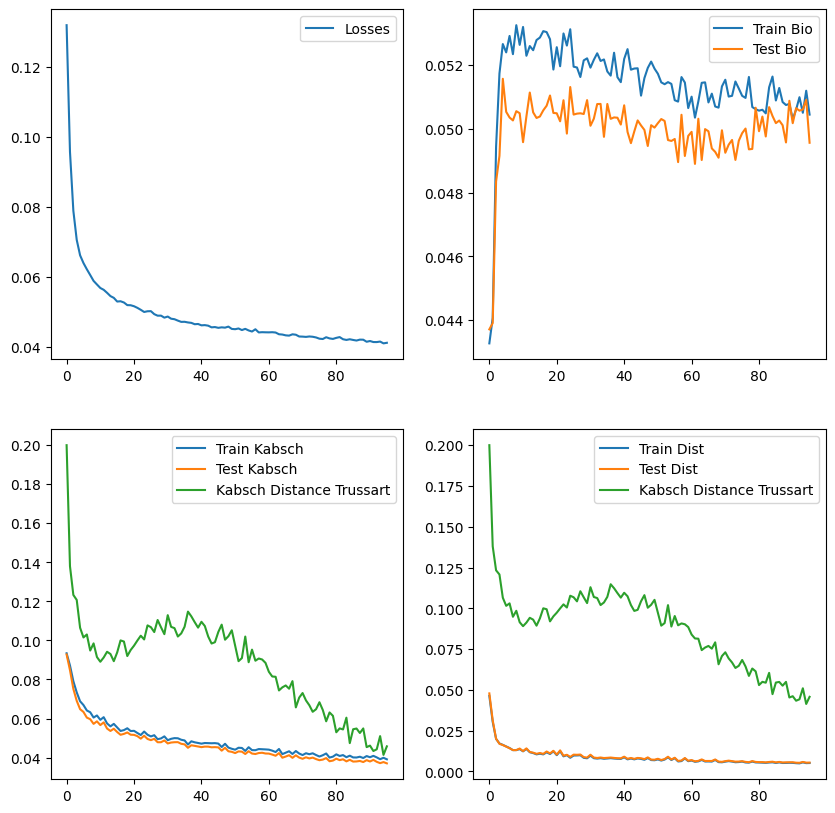

In [11]:
plot_losses(losses, train_biological_losses_all_epochs, test_biological_losses_all_epochs, train_kabsch_losses_all_epochs, test_kabsch_losses_all_epochs, trussart_test_kabsch_losses_all_epochs, train_distance_losses_all_epochs, test_distance_losses_all_epochs)


In [12]:
kabsch_distances = []

for graph_index in range(test_size):

    test_true_structure = test_true_structures[graph_index,:,:]
    test_pred_structure = test_pred_structures[graph_index,:,:]
    
    d = kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
    kabsch_distances.append(d)

In [13]:
GRAPH_TESTED = np.argmin(kabsch_distances)

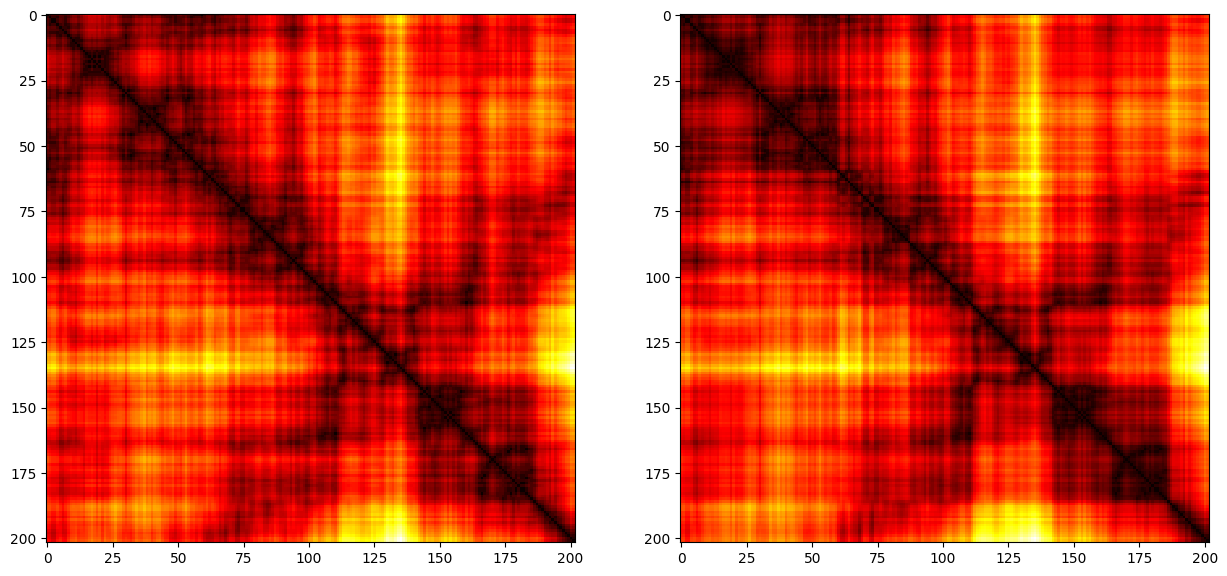

In [14]:
ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
plot_test_distance_matrix(ground_truth_matrix, reconstruction_matrix)

In [15]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.005977556635513775


<Figure size 50000x50000 with 0 Axes>

In [16]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]
pred_structure_unit_ball, true_structure_unit_ball = \
            kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
d = np.negative(np.log(np.mean(np.divide(np.abs(pred_structure_unit_ball - true_structure_unit_ball),np.abs(true_structure_unit_ball)), axis=1)))

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = d
color1 = 'Viridis'
color2 = 'magma'
plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.005977556635513775


<Figure size 50000x50000 with 0 Axes>

In [17]:
random_structure = np.random.random((202,3))
test_true_structure = test_true_structures[GRAPH_TESTED]
print(lddt(torch.from_numpy(test_pred_structure_superposed).unsqueeze(0), torch.from_numpy(test_true_structure_superposed).unsqueeze(0)))

random_structure_superposed, true_to_random_structure_superposed = \
        kabsch_superimposition_numpy(random_structure, test_true_structure, EMBEDDING_SIZE)

print(lddt(torch.from_numpy(random_structure_superposed).unsqueeze(0), torch.from_numpy(true_to_random_structure_superposed).unsqueeze(0)))
#print(test_true_structures[GRAPH_TESTED].shape)


tensor([0.9359], dtype=torch.float64)
tensor([0.5622], dtype=torch.float64)


In [21]:
# Trussart perfect structure
trussart_true_structure = np.mean(trussart_structures, axis=0)

# Trussart predicted structure
torch_trussart_hic = torch.FloatTensor(trussart_hic)
torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)

trussart_pred_structure, trussart_pred_distance, trussart_pred_logits = model(torch_trussart_hic)
trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]

# Superpose structure using Kabsch algorithm
trussart_pred_structure_superposed, trussart_true_structure_superposed = \
        kabsch_superimposition_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)

# Plot and compare the two structures
x_pred = trussart_pred_structure_superposed[:, 0]  
y_pred = trussart_pred_structure_superposed[:, 1]
z_pred = trussart_pred_structure_superposed[:, 2]

x_true = trussart_true_structure_superposed[:, 0]  
y_true = trussart_true_structure_superposed[:, 1]
z_true = trussart_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)/3))

Kabsch distance is 0.015115258930803096


<Figure size 50000x50000 with 0 Axes>

In [19]:
np.savetxt('non_ae_synthetic_random_linear_trussart_test_structure_150.txt', trussart_pred_structure)